# **LSTM原理跟算法**


<br>
  <a href="https://colab.research.google.com/drive/1zkQ45hUQu8dxuNtvMj0mrsgLlhh7dsLy?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<br>



## **LSTM原理**
LSTM（長短期記憶網絡）是一種特殊類型的循環神經網絡（RNN），專門設計用於解決長序列中的長期依賴問題。傳統的RNN在處理長序列時會遇到梯度消失或梯度爆炸的問題，這使得網絡難以學習和記憶遠距離的依賴關係。LSTM通過引入一種叫做“門”的機制來解決這個問題。

* LSTM的組成部分

  一個LSTM單元主要由以下幾個部分組成：

  * 遺忘門（Forget Gate）: 決定哪些信息從單元狀態（Cell State）中丟棄。
  * 輸入門（Input Gate）: 決定哪些新信息將存儲在單元狀態中。
  * 單元狀態（Cell State）: LSTM的“記憶”部分，存儲了過去的信息。
  * 輸出門（Output Gate）: 根據單元狀態和當前輸入，決定輸出什麼信息。

* LSTM的工作原理

  1. 遺忘門: LSTM首先決定要從單元狀態中丟棄哪些信息。這是通過一個sigmoid層完成的，它查看當前輸入和上一個隱藏狀態，並輸出一個在0到1之間的數值給每個在單元狀態中的數字。1表示“完全保留”，0表示“完全丟棄”。
  
  \begin{gather*}f_t​ =σ(W_f​⋅[h_{t−1}​ ,x_t​ ]+b_f​)\end{gather*}
  
  2. 輸入門: LSTM然後決定將哪些新信息存儲在單元狀態中。這分為兩步。首先，一個sigmoid層決定哪些值將更新。然後，一個tanh層創建一個新的候選值向量，可能會添加到狀態中。
  
  \begin{gather*}i _t​ =σ(W_i​ ⋅[h_{t−1}​ ,x_t​ ]+b_i​)\end{gather*}
  
  \begin{gather*}\tilde{C_t​} =tanh(W_C​ ⋅[h_{t−1}​ ,x_t​ ]+b_C​ )\end{gather*}

  3. 更新單元狀態: 現在，可以使用遺忘門的輸出和輸入門的輸出來更新單元狀態。
  
  \begin{gather*}C_t​ =f_t​ ∗C_{t−1}​ +i_t​ ∗ \tilde{C_t} \end{gather*}
  
  4. 輸出門: 最後，決定輸出什麼值。輸出依賴於單元狀態，但是是一個過濾後的版本。首先，運行一個sigmoid層來決定單元狀態的哪個部分將輸出。然後，將單元狀態通過tanh（將值推到-1和1之間）並將它與sigmoid門的輸出相乘，以便只輸出決定輸出的部分。
  
  \begin{gather*}o_t​ =σ(W_o​ ⋅[h_{t−1}​ ,x_t​ ]+b_o​ )\end{gather*}
  
  \begin{gather*}h_t​ =o_t​ ∗tan_h(C_t​ )\end{gather*}
  
  這些步驟共同使LSTM能夠在長序列中有效地學習長期依賴。

## **LSTM 算法 Tensorflow 實現**

In [14]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math

# 設定下載的網址以及文件名
baseURL = "https://github.com/markl-a/ML-demos/raw/main/4.LSTM/"
fileNames = ["prices-split-adjusted.csv"]

# 根據文件輪詢並下載
for fileName in fileNames:
    # 創照完整連結
    fullURL = baseURL + fileName

    # 傳送 HTTP 的 request 並將內容轉到 response
    response = requests.get(fullURL)

    # 檢查是否有成功傳輸
    if response.status_code == 200:
        # 在colab虛擬機存下檔案
        with open(fileName, 'wb') as file:
            file.write(response.content)
        print(f"{fileName} has been downloaded successfully.")
    else:
        print(f"Failed to download {fileName}.")

prices-split-adjusted.csv has been downloaded successfully.


In [15]:
# 讀取CSV文件並選擇只有GOOG股票的數據
dataDf = pd.read_csv("prices-split-adjusted.csv", index_col=0)
dataDf = dataDf[dataDf.symbol == 'GOOG']

# 移除'symbol'列並將索引轉換為datetime格式
dataDf.drop(['symbol'], axis=1, inplace=True)
dataDf['date'] = pd.to_datetime(dataDf.index)

In [16]:
# LSTM 對輸入數據的數值非常敏感，特別是當使用 sigmoid（默認）或 tanh 激活函數時。
# 把資料重新調整到 0 到 1 的範圍之間（也稱為正規化或歸一化(0~1)）是一個好的方法。
minMaxScaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataSet = minMaxScaler.fit_transform(dataDf['close'].values.reshape(-1, 1))

In [17]:
# 把資料分成訓練跟測試集
trainSize = int(len(dataSet) * 0.7)
testSize = len(dataSet) - trainSize
trainData, testData = dataSet[0:trainSize, :], dataSet[trainSize:len(dataSet), :]
print(len(trainData), len(testData))

1233 529


In [18]:
# 我將回望日期設為15天，這是用作輸入變數以預測下一個時間段的先前時間步數。
# 將一組值轉換為數據集矩陣。
def createDataset(dataSet, lookBack=15):
    dataX, dataY = [], []
    for i in range(len(dataSet) - lookBack - 1):
        a = dataSet[i:(i + lookBack), 0]
        dataX.append(a)
        dataY.append(dataSet[i + lookBack, 0])
    return np.array(dataX), np.array(dataY)

xTrain, yTrain = createDataset(trainData, lookBack=15)
xTest, yTest = createDataset(testData, lookBack=15)


In [20]:
# LSTM 網絡期望輸入數據（X）以特定的數組結構提供，形式為：[樣本數，時間步長，特徵數]。
# 目前，這些數據的形式是：[樣本數，特徵數]，而我們將問題框定為每個樣本一個時間步長。我們可以使用 numpy.reshape()
# 將準備好的訓練和測試輸入數據轉換為預期的結構，如下所示：
xTrain = np.reshape(xTrain, (xTrain.shape[0], 1, xTrain.shape[1]))
xTest = np.reshape(xTest, (xTest.shape[0], 1, xTest.shape[1]))


此LSTM網絡具有一個可見層，其中包含1個輸入，一個隱藏層包含20個LSTM塊或神經元，以及一個輸出層用於進行15值預測。LSTM塊使用默認的Sigmoid激活函數。網絡訓練進行了20個訓練週期（epochs），並使用了批量大小（batch size）為1。

In [21]:
# 建立跟訓練 LSTM 網路
# 超參數設定
lookBack = 15
epochs = 20
batchSize = 1

# 建立 LSTM 模型
model = Sequential([
    LSTM(20, input_shape=(1, lookBack)),
    Dense(1)
])

# 編譯模型
model.compile(loss='mean_squared_error', optimizer='adam')

# 訓練模型
model.fit(xTrain, yTrain, epochs=epochs, batch_size=batchSize, verbose=1)

Epoch 1/20
1217/1217 [==============================] - 3s 2ms/step - loss: 0.0015
Epoch 2/20
1217/1217 [==============================] - 2s 2ms/step - loss: 4.1920e-04
Epoch 3/20
1217/1217 [==============================] - 2s 2ms/step - loss: 3.1625e-04
Epoch 4/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.4022e-04
Epoch 5/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.3027e-04
Epoch 6/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.3037e-04
Epoch 7/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.1094e-04
Epoch 8/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.0287e-04
Epoch 9/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.0949e-04
Epoch 10/20
1217/1217 [==============================] - 2s 2ms/step - loss: 2.0608e-04
Epoch 11/20
1217/1217 [==============================] - 2s 2ms/step - loss: 1.9215e-04
Epoch 12/20
1217/1217 [======================

In [22]:
trainPredict = model.predict(xTrain)
testPredict = model.predict(xTest)
# 逆變換預測
trainPredict = minMaxScaler.inverse_transform(trainPredict)
trainY = minMaxScaler.inverse_transform([yTrain])
testPredict = minMaxScaler.inverse_transform(testPredict)
testY = minMaxScaler.inverse_transform([yTest])
# 計算均方根誤差
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print(f'Test Score: {testScore:.2f} RMSE')

17/17 [==============================] - 0s 2ms/step
Train Score: 7.30 RMSE
Test Score: 37.68 RMSE


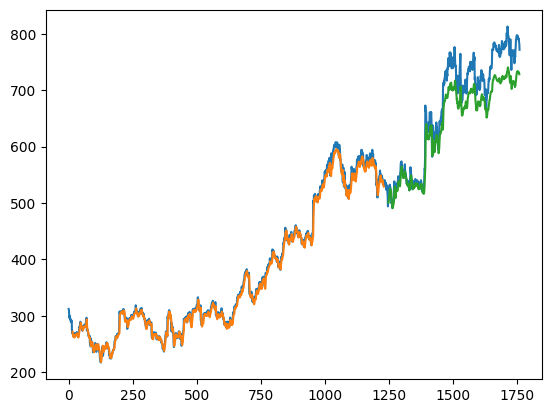

In [23]:
# 為繪圖而調整訓練預測
lookBack = 15
trainPredictPlot = np.empty_like(dataSet)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookBack:len(trainPredict) + lookBack, :] = trainPredict
# 為繪圖而調整測試預測
testPredictPlot = np.empty_like(dataSet)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (lookBack * 2) + 1:len(dataSet) - 1, :] = testPredict
# 畫出 baseline 跟預測
plt.plot(minMaxScaler.inverse_transform(dataSet))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **GRU原理跟算法**


## **GRU原理**
GRU（門控遞歸單元，Gated Recurrent Unit）是一種用於遞歸神經網絡（RNN）的特殊類型的激活單元。GRU 是由 Cho 等人在 2014 年提出的，旨在解決傳統 RNN 在處理長序列時面臨的梯度消失和梯度爆炸問題。

### 基本結構

GRU 的基本結構包括兩個門：

1. 更新門（Update Gate）：決定何時更新隱藏狀態。
2. 重置門（Reset Gate）：決定隱藏狀態在多大程度上應該保留之前的信息。

### 數學公式

以下是 GRU 的數學表示：

* 更新門：$z_t =σ(W_z ⋅[h_{t−1},x_t])$

* 重置門：$r_t =σ(W_r ⋅[h _{t−1},x _t])$

* 候選隱藏狀態：$\tilde{h_t}=tanh(W⋅[r_t∗h_{t−1},x_t ])$

* 最終隱藏狀態：$h_t=(1−z_t)∗h_{t−1}+z_t∗\tilde{h_t}$

其中，σ 是 Sigmoid 激活函數，tanh 是雙曲正切激活函數，∗ 表示逐元素乘法。

### 工作原理

1. 更新門：決定了當前輸入和過去的隱藏狀態應該在多大程度上影響當前的隱藏狀態。
2. 重置門：用於決定過去的隱藏狀態在多大程度上應該與當前的輸入交互。
3. 候選隱藏狀態：是基於當前輸入和過去隱藏狀態（經過重置門調整）的一個新的隱藏狀態。
4. 最終隱藏狀態：是基於更新門、候選隱藏狀態和過去隱藏狀態的一個加權平均。

### 優點

* 相對於傳統的 RNN，GRU 能更好地捕捉長距離依賴。
* 計算複雜性較 LSTM 稍低，因為它只有兩個門。

### 應用場景

GRU 常用於自然語言處理（NLP）、時間序列分析、語音識別等任務。

## LSTM 和 GRU的主要區別

### 門的數量：

* LSTM 有三個門：遺忘門、輸入門和輸出門。
* GRU 只有兩個門：更新門和重置門。

### 隱藏狀態和單元狀態：

* LSTM 有兩種狀態：隱藏狀態和單元狀態。
* GRU 只有一種狀態：隱藏狀態。

### 計算複雜性：

* LSTM 的結構較為複雜，因此計算成本較高。
* GRU 的結構較為簡單，因此計算成本較低。

### 參數數量：

* LSTM 有更多的參數，因此需要更多的訓練時間。
* GRU 有較少的參數，因此訓練速度可能較快。

### 長距離依賴：

* LSTM 通常更擅長捕捉長距離依賴。
* GRU 在某些情況下可能無法捕捉到非常長的依賴。

### 應用場景：

* LSTM 常用於更複雜的序列預測問題。
* GRU 則常用於較短的序列或者計算資源有限的情況。

### 訓練效率：

* 由於 GRU 有較少的參數和簡單的結構，它通常更容易訓練。
* LSTM 由於有更多的參數和複雜的結構，可能需要更多的訓練時間。

## **GRU 算法 Tensorflow 實現**

prices-split-adjusted.csv has been downloaded successfully.
Epoch 1/100
973/973 [==============================] - 4s 2ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 2/100
973/973 [==============================] - 3s 3ms/step - loss: 9.8697e-04 - val_loss: 5.5903e-04
Epoch 3/100
973/973 [==============================] - 2s 2ms/step - loss: 6.4775e-04 - val_loss: 4.3681e-04
Epoch 4/100
973/973 [==============================] - 2s 2ms/step - loss: 6.6024e-04 - val_loss: 6.1004e-04
Epoch 5/100
973/973 [==============================] - 2s 2ms/step - loss: 5.1995e-04 - val_loss: 2.6691e-04
Epoch 6/100
973/973 [==============================] - 2s 2ms/step - loss: 5.1206e-04 - val_loss: 2.8203e-04
Epoch 7/100
973/973 [==============================] - 4s 4ms/step - loss: 4.9489e-04 - val_loss: 0.0013
Epoch 8/100
973/973 [==============================] - 2s 2ms/step - loss: 5.2046e-04 - val_loss: 2.2174e-04
Epoch 9/100
973/973 [==============================] - 2s 2ms/step - loss: 4.480

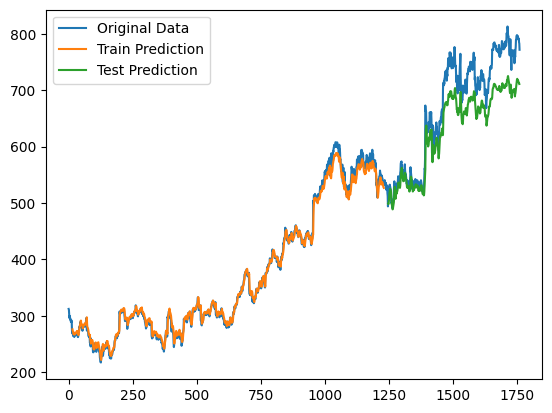

In [13]:
import numpy as np  # 引入NumPy庫用於數學運算
import pandas as pd  # 引入Pandas庫用於數據處理
import requests  # 引入requests庫用於HTTP請求
import matplotlib.pyplot as plt  # 引入Matplotlib庫用於繪圖
from sklearn.preprocessing import MinMaxScaler  # 引入MinMaxScaler用於數據標準化
from sklearn.metrics import mean_squared_error  # 引入mean_squared_error用於計算MSE
from tensorflow.keras.models import Sequential  # 引入Sequential模型
from tensorflow.keras.layers import Dense, GRU, Dropout  # 引入Dense、GRU和Dropout層
from tensorflow.keras.callbacks import EarlyStopping  # 引入EarlyStopping用於提前停止訓練
import math  # 引入math庫用於數學運算

# 下載文件的函數
def downloadFile(baseUrl, fileName):
    fullUrl = f"{baseUrl}{fileName}"
    response = requests.get(fullUrl)
    if response.status_code == 200:
        with open(fileName, 'wb') as f:
            f.write(response.content)
        print(f"{fileName} has been downloaded successfully.")
    else:
        print(f"Failed to download {fileName}.")

# 創建數據集的函數
def createDataset(dataset, lookBack=15):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack - 1):
        dataX.append(dataset[i:i + lookBack, 0])
        dataY.append(dataset[i + lookBack, 0])
    return np.array(dataX), np.array(dataY)

# 下載文件
baseUrl = "https://github.com/markl-a/ML-demos/raw/main/4.LSTM/"
fileNames = ["prices-split-adjusted.csv"]
for fileName in fileNames:
    downloadFile(baseUrl, fileName)

# 數據預處理
dataDf = pd.read_csv("prices-split-adjusted.csv", index_col=0)
dataDf = dataDf[dataDf.symbol == 'GOOG'].drop(['symbol'], axis=1)
dataDf['date'] = pd.to_datetime(dataDf.index)

# 數據標準化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataDf['close'].values.reshape(-1, 1))

# 訓練測試集分割
trainSize = int(len(dataset) * 0.7)
train, test = dataset[:trainSize], dataset[trainSize:]

# 創建數據集
xTrain, yTrain = createDataset(train)
xTest, yTest = createDataset(test)
xTrain = np.reshape(xTrain, (xTrain.shape[0], 1, xTrain.shape[1]))
xTest = np.reshape(xTest, (xTest.shape[0], 1, xTest.shape[1]))

# 建立和訓練GRU模型
model = Sequential([
    GRU(20, input_shape=(1, 15), recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
earlyStop = EarlyStopping(monitor='val_loss', patience=10)
model.fit(xTrain, yTrain, epochs=100, batch_size=1, verbose=1, validation_split=0.2, callbacks=[earlyStop])

# 預測和評估
trainPredict = model.predict(xTrain)
testPredict = model.predict(xTest)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainScore = math.sqrt(mean_squared_error(yTrain, trainPredict[:, 0]))
testScore = math.sqrt(mean_squared_error(yTest, testPredict[:, 0]))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')

# 繪圖
lookBack = 15
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookBack:len(trainPredict) + lookBack, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (lookBack * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()
